In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/My Drive/Тест_Спутник_Арбузина_АА/events_filters.csv')

### Описание входных данных:

* 1 строка =  1 вариант совершенного события
* event action - название действия события, где Page Visit - всегда посещение (= пользователь открыл страницу сайта), остальные события - всегда клики по элементам страницы (кнопки, чекбоксы), где элементы - это фильтры на мобильной версии сайта.
* event label - дополнительная информация по событию в лейбле на 1 месте всегда название города. Там, где в лейбле через / написано что-то еще - это текст, по которому пользователь кликнул. Там встречается много грязных данных!!!
* metrics: это количество всех (total events) и уникальных (unique events) событий, которые были затреканы на сайте
* event_category - равно 'City Page' для event action = Page Visit; равно 'city_landing' для остальных event action
* *важно! в event label много грязных данных, оттуда можно убрать числа.
* там могут встречаться разные вещи.
* это нормально, поступай с этим так, как тебе покажется правильным

In [ ]:
data.head(15)

,event_category,event_action,event_label,total_events,unique_events
0,city_landing,price_button_submit,Tula / Показать предложения (11),8,7
1,city_landing,price_button_submit,Sochi / Показать предложения (39),12,10
2,city_landing,search-tools-button_open,Penza / Сортировка,2,2
3,city_landing,filters-categories_click,Gelendzhik / ЭКСКУРСИИ В ГЕЛЕНДЖИКЕ ЦЕНЫ,1,1
4,city_landing,price_button_submit,Moscow / Показать предложения (345),2,2
5,city_landing,clear_filter_mobile,Vienna,12,11
6,city_landing,start_date_click,Vilnius,9,4
7,city_landing,ticket-type_checkbox,Irkutsk / Мини-группа,29,26
8,city_landing,price_button_submit,Vladivostok / Показать предложения (28),3,3
9,city_landing,filters-categories_click,Krakow / Необычные,3,3


In [ ]:
# Проверю типы данных и пропуски значений
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19092 entries, 0 to 19091
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   event_category  19092 non-null  object
 1   event_action    19092 non-null  object
 2   event_label     19092 non-null  object
 3   total_events    19092 non-null  int64 
 4   unique_events   19092 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 745.9+ KB


# Задача 1 - Анализ использования фильтров на сайте

### Вопрос 1

> Сколько людей пользуются фильтрами?

Входные данные представлены в агрегированном виде (даны суммарные значения `total_events`, `unique_events` по каждому действию). Поскольку отсутствует информация о пользовательских сессиях, нельзя сделать вывод о том, какой набор действий совершил каждый пользователь и дать точный ответ - сколько людей в данной выборке пользовались фильтрами

Пример: для выборки ниже нельзя сказать - оба действия сделал 1 пользователь или 2 разных пользователя

In [ ]:
data.query('event_action == "price_button_submit" & event_label.str.contains("Moscow") & total_events == 1').head(2)

,event_category,event_action,event_label,total_events,unique_events
111,city_landing,price_button_submit,Moscow / Показать предложения (453),1,1
1650,city_landing,price_button_submit,Moscow / Показать предложения (350),1,1


Однако можно назвать границы числа пользователей, использующих фильтры в данной выборке - назвать минимальное и максимальное возможное число пользователей.
Минимальное число вычисляется как максимум колонки `unique_events` для действий с фильтрами - какое-то действие с фильтром объективно совершило столько человек, а все остальные действия совершали эти же люди.
Максимальное число - сумма значений `unique_events` для действий с фильтрами, то есть каждое уникальное действие (якобы) совершали уникальные пользователи, но не более, чем сумма уникальных посещений страниц городов `event_action` = "Page Visit" (т.к. после перехода на страницу города начинается фильтрация событий)

In [ ]:
# Минимальная граница числа людей, пользующихся фильтрами
data.query('event_action != "Page Visit"').unique_events.max()

1615

In [ ]:
# Максимальная граница числа людей, пользующихся фильтрами
min(
    data.query('event_action != "Page Visit"').unique_events.sum(),
    data.query('event_action == "Page Visit"').unique_events.sum()
)

np.int64(294969)

P.S. Зашла на сайт и проверила, что для активации фильтра необязательно нажимать кнопку "Показать предложения", поэтому не выделила это действие из исходого набора данных. Однако, если считать за пользование фильтром нажатие кнопки "Показать предложения", то по логике выше оценки будут следующими

In [ ]:
# Минимальная граница числа людей, пользующихся фильтрами
data.query('event_action == "price_button_submit"').unique_events.max()

242

In [ ]:
# Максимальная граница числа людей, пользующихся фильтрами
min(
    data.query('event_action == "price_button_submit"').unique_events.sum(),
    data.query('event_action == "Page Visit"').unique_events.sum()
)

np.int64(63063)

P.P.S
Оценить число реальных пользователей, пользующихся фильтрами, можно, поделив максимальную границу на среднее число действий с фильтрами одного пользователя (при наличии таких данных)

### Вопрос 2

> В каких городах фильтрами пользуются больше? в каких меньше?

Необходимо определить, на страницах каких городов люди чаще/реже используют фильтры

Для этого можно использовать 2 метрики:
* абсолютное значение - посчитать сумму числа использоания фильтров для каждого города,
* относительное значение - посчитать частоту применения фильтров на каждый заход на страницу для каждого города.

Решим обе задачи

#### 2.1 На страницах каких городов люди чаще / реже используют фильтры в абсолютном значении

In [ ]:
# Чтобы не вносить правки в исходный датасет, сделаю его копию
data_with_cities = data.copy()

In [ ]:
# Выделю из event_label название города
data_with_cities['city'] = data.event_label.str.split(' / ').str.get(0)

In [ ]:
data_with_cities.head()

,event_category,event_action,event_label,total_events,unique_events,city
0,city_landing,price_button_submit,Tula / Показать предложения (11),8,7,Tula
1,city_landing,price_button_submit,Sochi / Показать предложения (39),12,10,Sochi
2,city_landing,search-tools-button_open,Penza / Сортировка,2,2,Penza
3,city_landing,filters-categories_click,Gelendzhik / ЭКСКУРСИИ В ГЕЛЕНДЖИКЕ ЦЕНЫ,1,1,Gelendzhik
4,city_landing,price_button_submit,Moscow / Показать предложения (345),2,2,Moscow


Для получения городов, в которых люди чаще / реже пользуются фильтрами, необходимо все события по фильтрам сгруппировать по городам и выполнить агрегацию - суммировать число использований фильтров
Поскольку необходимо оценить общее использование фильтров, нужно учитывать не `unique_events`, а `total_events`

In [ ]:
filter_usage_by_city = data_with_cities.query('event_action != "Page Visit"') \
                                        .groupby('city', as_index=False) \
                                        .agg({'total_events': 'sum'})
filter_usage_by_city.head()

,city,total_events
0,Abakan,42
1,Abkhazia,22
2,Abrau-Durso,238
3,Abu Dhabi,145
4,Adler,6503


In [ ]:
# Топ 10 городов, на страницах которых чаще всего пользуются фильтрами (в абсолютном значении)
top_cities_by_filter_usage_absolute = filter_usage_by_city.sort_values('total_events', ascending=False).head(10)
top_cities_by_filter_usage_absolute

,city,total_events
149,Kaliningrad,31776
299,Saint Petersburg,30006
222,Moscow,19154
324,Sochi,15286
139,Istanbul,14087
91,Dubai,10388
156,Kazan,10095
59,Budapest,9958
15,Anapa,8753
164,Kislovodsk,7800


In [ ]:
# Топ 10 городов, на страницах которых реже всего пользуются фильтрами (в абсолютном значении)
filter_usage_by_city.sort_values('total_events').head(10)

,city,total_events
49,Bonn,1
71,Chambery,1
78,Chita,1
55,Bruges,1
339,Sydney,1
262,Pechory,1
138,Ischia,1
220,Montevideo,1
251,Orlando,1
130,Hluboká nad Vltavou,1


#### 2.2 На страницах каких городов люди чаще / реже используют фильтры на каждое посещение страницы города

Для этого поделю число суммарное число событий по фильтрам города на количество посещений данного города

In [ ]:
# Проверю, что в колонке с event_action = "Page Visit" содержатся только уникальные города
data_with_cities.query('event_action == "Page Visit"').city.nunique() == data_with_cities.query('event_action == "Page Visit"').city.count()

np.True_

In [ ]:
page_visits = data_with_cities \
    .query('event_action == "Page Visit"')[['city', 'total_events']] \
    .rename(columns={'total_events': 'page_visits'})

filter_usage_per_city = filter_usage_by_city \
    .rename(columns={'total_events': 'total_filter_events'}) \
    .merge(page_visits, how='inner', on='city')

filter_usage_per_city.head()

,city,total_filter_events,page_visits
0,Abakan,42,158
1,Abkhazia,22,327
2,Abrau-Durso,238,4823
3,Abu Dhabi,145,786
4,Adler,6503,34568


In [ ]:
filter_usage_per_city['freq'] = filter_usage_per_city.total_filter_events / filter_usage_per_city.page_visits
filter_usage_per_city.head()

,city,total_filter_events,page_visits,freq
0,Abakan,42,158,0.265823
1,Abkhazia,22,327,0.067278
2,Abrau-Durso,238,4823,0.049347
3,Abu Dhabi,145,786,0.184478
4,Adler,6503,34568,0.188122


In [ ]:
# Топ 10 городов, по пользованию фильтрами на каждое посещение страницы города
filter_usage_per_city.sort_values(['freq', 'page_visits'], ascending=[False, False]).head(15)

,city,total_filter_events,page_visits,freq
327,Sovetsk,5,1,5.000000
235,Nevyansk,6,4,1.500000
215,Miass,16,12,1.333333
332,Stresa,4,3,1.333333
343,Tartu,4,3,1.333333
12,Amiens,7,6,1.166667
93,Durban,25,27,0.925926
298,Rzhev,18,20,0.900000
203,Manama,8,11,0.727273
404,bogolyubovo,4,6,0.666667


Чтобы увидеть более репрезентативную картину, добавлю фильтр количества посещений страницы города - от 10 и от 50 посещений

In [ ]:
# Топ 10 городов, по пользованию фильтрами на каждое посещение страницы города (от 10 посещений страницы города)
filter_usage_per_city[filter_usage_per_city.page_visits >= 10].sort_values(['freq', 'page_visits'], ascending=[False, False]).head(15)

,city,total_filter_events,page_visits,freq
215,Miass,16,12,1.333333
93,Durban,25,27,0.925926
298,Rzhev,18,20,0.900000
203,Manama,8,11,0.727273
349,The Hague,27,42,0.642857
189,Ljubljana,109,177,0.615819
179,Larnaca,778,1296,0.600309
63,Cadiz,13,22,0.590909
70,Catania,11,19,0.578947
256,Paphos,514,895,0.574302


In [ ]:
# Топ 10 городов, по пользованию фильтрами на каждое посещение страницы города (от 30 посещений страницы города)
top_cities_by_filter_usage_relative = filter_usage_per_city[filter_usage_per_city.page_visits >= 30].sort_values(['freq', 'page_visits'], ascending=[False, False]).head(10)
top_cities_by_filter_usage_relative

,city,total_filter_events,page_visits,freq
349,The Hague,27,42,0.642857
189,Ljubljana,109,177,0.615819
179,Larnaca,778,1296,0.600309
256,Paphos,514,895,0.574302
40,Belgrade,902,1613,0.559206
24,Ayia Napa,1407,2591,0.543034
198,Magas,16,32,0.500000
374,Verona,40,85,0.470588
394,Yerevan,4408,9524,0.462831
22,Atlantic City,19,43,0.441860


Вывод: После применения фильтра по page_visits в топе остались только иностранные (нероссийские) города. Можно предположить, что если в этих городах люди заходят в сервис, то проводят там какое-то время - реально пытаются найти экскурсию (т.е. пользуются фильтрами)

В относительном значении в этих городах часто пользуются фильтрами

In [ ]:
# Топ 10 городов, по наименьшему пользованию фильтрами на каждое посещение страницы города (от 10 посещений страницы города)
filter_usage_per_city[filter_usage_per_city.page_visits >= 10].sort_values(['freq', 'page_visits'], ascending=[True, False]).head(15)

,city,total_filter_events,page_visits,freq
241,Noginsk,1,117,0.008547
262,Pechory,1,115,0.008696
295,Rovinj,1,64,0.015625
359,Tunis,3,183,0.016393
78,Chita,1,60,0.016667
129,Herzliya,1,59,0.016949
344,Tarusa,2,117,0.017094
238,Nha Trang,10,539,0.018553
115,Goa,28,1499,0.018679
87,Diveevo,1,53,0.018868


In [ ]:
# Топ 10 городов, по наименьшему пользованию фильтрами на каждое посещение страницы города
# (от 10 посещений страницы города и от 30 действий с фильтрами)
filter_usage_per_city[(filter_usage_per_city.page_visits >= 10) & (filter_usage_per_city.total_filter_events >= 30)].sort_values(['freq', 'page_visits'], ascending=[True, False]).head(15)

,city,total_filter_events,page_visits,freq
75,Chernobyl,142,4009,0.035420
142,Izberbash,35,911,0.038419
236,New Athos,112,2720,0.041176
160,Khabarovsk,45,1034,0.043520
19,Astana,101,2126,0.047507
2,Abrau-Durso,238,4823,0.049347
154,Kaspiysk,63,1227,0.051345
369,Varadero,70,1282,0.054602
320,Simeiz,51,904,0.056416
248,Omsk,110,1922,0.057232


Выводы - в топе с конца представлены города, на которые пользователи заходят, но дальше не применяют фильтры.
Результат маленькой "конверсии" - либо рекламный трафик на эти страницы городов, либо люди заходят на страницу, видят результаты и по какой-то причине у них отпадает желание искать экскурсии (мало предложений, дорогие экскурсии, было просто интересно узнать какие экскурсии вообще есть в этом городе или какие-то другие причины)

Посмотрим на частоты использования фильтров для самых популярных городов по абсолютному числу использования фильтров (из прошлого подпункта)

In [ ]:
MOST_POPULAR_CITIES_BY_ABSOLUTE_FILTER_USAGE = set(filter_usage_by_city.sort_values('total_events', ascending=False).head(10).city)
MOST_POPULAR_CITIES_BY_ABSOLUTE_FILTER_USAGE

{'Anapa',
 'Budapest',
 'Dubai',
 'Istanbul',
 'Kaliningrad',
 'Kazan',
 'Kislovodsk',
 'Moscow',
 'Saint Petersburg',
 'Sochi'}

In [ ]:
filter_usage_per_city[filter_usage_per_city.city.isin(MOST_POPULAR_CITIES_BY_ABSOLUTE_FILTER_USAGE)].sort_values('freq', ascending=False)

,city,total_filter_events,page_visits,freq
59,Budapest,9958,24542,0.405753
149,Kaliningrad,31776,111181,0.285804
139,Istanbul,14087,56073,0.251226
324,Sochi,15286,64054,0.238642
91,Dubai,10388,51377,0.202192
164,Kislovodsk,7800,42799,0.182247
15,Anapa,8753,63348,0.138173
156,Kazan,10095,74472,0.135554
222,Moscow,19154,202253,0.094703
299,Saint Petersburg,30006,350560,0.085594


Заметно отсутствие взаимосвязи между этими топами

### Вопрос 3

> Какие разделы фильтров наиболее востребованы? “фильтры”, “сортировка”, “категории”?

Поделим все фильтры на группы: "фильтры", "сортировки", "категории"

Согласно описанию входных данных сортировки и категории присутствуют только в строках с `event_action` = "filters-categories_click", а использование фильтров - в действиях с `event_action` = "price_button_submit", "ticket-type_checkbox", "start_date_click", "end_date_click", "dates_filter_mobile", "price_first", "pay-type_checkbox", "clear_filter_mobile", "price_second", "price_third". Действия вроде "Открыть/закрыть окошко с фильтрами" учитывать не будем

In [ ]:
FILTERS_EVENT_ACTIONS = {"price_button_submit", "ticket-type_checkbox", "start_date_click", "end_date_click", "dates_filter_mobile", "price_first", "pay-type_checkbox", "clear_filter_mobile", "price_second", "price_third"}
filters = data[data.event_action.isin(FILTERS_EVENT_ACTIONS)]
filters.head()

,event_category,event_action,event_label,total_events,unique_events
0,city_landing,price_button_submit,Tula / Показать предложения (11),8,7
1,city_landing,price_button_submit,Sochi / Показать предложения (39),12,10
4,city_landing,price_button_submit,Moscow / Показать предложения (345),2,2
5,city_landing,clear_filter_mobile,Vienna,12,11
6,city_landing,start_date_click,Vilnius,9,4


Посмотрим на события с `event_action` = "filters-categories_click"

In [ ]:
data[data.event_action == "filters-categories_click"].head(10)

,event_category,event_action,event_label,total_events,unique_events
3,city_landing,filters-categories_click,Gelendzhik / ЭКСКУРСИИ В ГЕЛЕНДЖИКЕ ЦЕНЫ,1,1
9,city_landing,filters-categories_click,Krakow / Необычные,3,3
11,city_landing,filters-categories_click,Barcelona / Сначала самые дешевые,62,50
12,city_landing,filters-categories_click,Novorossiysk / Автобусные,42,32
15,city_landing,filters-categories_click,Sergiev Posad / Групповые,10,8
23,city_landing,filters-categories_click,Saint Petersburg / СЕМЕЙНЫЕ ЭКСКУРСИИ В ПЕТЕРБ...,2,1
26,city_landing,filters-categories_click,Tula / Обзорные,23,17
46,city_landing,filters-categories_click,Novosibirsk / Популярные,33,24
47,city_landing,filters-categories_click,Kolomna / Гастрономические,4,4
62,city_landing,filters-categories_click,Hurghada / Выездные,45,38


Заметно, что действия по сортировкам и категориям перемешаны, их можно различить по подзаголовку (после слэша) в `event_label`
Вынесем эти подзаголовки в отдельную колонку, чтобы разделить категории и сортировки

In [ ]:
categories_and_sorts = data[data.event_action == 'filters-categories_click'].copy()
categories_and_sorts['category_or_sort']  = categories_and_sorts.event_label.str.split(' / ').str.get(1).str.lower()
categories_and_sorts.head(10)

,event_category,event_action,event_label,total_events,unique_events,category_or_sort
3,city_landing,filters-categories_click,Gelendzhik / ЭКСКУРСИИ В ГЕЛЕНДЖИКЕ ЦЕНЫ,1,1,экскурсии в геленджике цены
9,city_landing,filters-categories_click,Krakow / Необычные,3,3,необычные
11,city_landing,filters-categories_click,Barcelona / Сначала самые дешевые,62,50,сначала самые дешевые
12,city_landing,filters-categories_click,Novorossiysk / Автобусные,42,32,автобусные
15,city_landing,filters-categories_click,Sergiev Posad / Групповые,10,8,групповые
23,city_landing,filters-categories_click,Saint Petersburg / СЕМЕЙНЫЕ ЭКСКУРСИИ В ПЕТЕРБ...,2,1,семейные экскурсии в петербурге
26,city_landing,filters-categories_click,Tula / Обзорные,23,17,обзорные
46,city_landing,filters-categories_click,Novosibirsk / Популярные,33,24,популярные
47,city_landing,filters-categories_click,Kolomna / Гастрономические,4,4,гастрономические
62,city_landing,filters-categories_click,Hurghada / Выездные,45,38,выездные


Оставим только уникальные категории и сортировки и выделим из них сортировки "руками" (т.к. увидела на сайте, что сортировок значительно меньше, чем категорий)

In [ ]:
categories_and_sorts.category_or_sort.unique()

array(['экскурсии в геленджике цены', 'необычные',
       'сначала самые дешевые', 'автобусные', 'групповые',
       'семейные экскурсии в петербурге', 'обзорные', 'популярные',
       'гастрономические', 'выездные', 'экскурсии по г москва',
       'фотопрогулки', 'пешеходные', 'индивидуальные', 'по рейтингу',
       'вечерние экскурсии', 'саратовский лимонарий', 'автобусні',
       'сначала самые популярные', 'водные экскурсии в казани',
       'светлогорск', 'история и культура', 'авторские',
       'экскурсии в нижнем новгороде цены',
       'обзорная экскурсия по новосибирску', 'однодневные', 'музеи',
       'по уралу', 'для детей', 'экскурсии по шарм эль шейху',
       'парк цветов', 'билеты без очереди', 'ночные экскурсии',
       'заказать экскурсию в нижнем новгороде', 'экскурсии будапешт',
       'экскурсия по суздалю заказать',
       'прага достопримечательности экскурсии',
       'калининград экскурсии по городу',
       'однодневные экскурсии из твери на автобусе',
       

In [ ]:
SORT_TYPES = {'по рейтингу', 'сначала самые дешевые', 'сначала самые популярные', 'by rating', 'cheapest first', 'most popular first','הפופולרי ביותר ראשון'}

In [ ]:
categories = categories_and_sorts[~categories_and_sorts.category_or_sort.isin(SORT_TYPES)]
categories.head(10)

,event_category,event_action,event_label,total_events,unique_events,category_or_sort
3,city_landing,filters-categories_click,Gelendzhik / ЭКСКУРСИИ В ГЕЛЕНДЖИКЕ ЦЕНЫ,1,1,экскурсии в геленджике цены
9,city_landing,filters-categories_click,Krakow / Необычные,3,3,необычные
12,city_landing,filters-categories_click,Novorossiysk / Автобусные,42,32,автобусные
15,city_landing,filters-categories_click,Sergiev Posad / Групповые,10,8,групповые
23,city_landing,filters-categories_click,Saint Petersburg / СЕМЕЙНЫЕ ЭКСКУРСИИ В ПЕТЕРБ...,2,1,семейные экскурсии в петербурге
26,city_landing,filters-categories_click,Tula / Обзорные,23,17,обзорные
46,city_landing,filters-categories_click,Novosibirsk / Популярные,33,24,популярные
47,city_landing,filters-categories_click,Kolomna / Гастрономические,4,4,гастрономические
62,city_landing,filters-categories_click,Hurghada / Выездные,45,38,выездные
72,city_landing,filters-categories_click,Side / Выездные,7,7,выездные


In [ ]:
sorts = categories_and_sorts[categories_and_sorts.category_or_sort.isin(SORT_TYPES)]
sorts.head(10)

,event_category,event_action,event_label,total_events,unique_events,category_or_sort
11,city_landing,filters-categories_click,Barcelona / Сначала самые дешевые,62,50,сначала самые дешевые
130,city_landing,filters-categories_click,Florence / По рейтингу,2,2,по рейтингу
193,city_landing,filters-categories_click,Bryansk / Сначала самые популярные,1,1,сначала самые популярные
266,city_landing,filters-categories_click,Grozny / Сначала самые дешевые,22,20,сначала самые дешевые
288,city_landing,filters-categories_click,Thessaloniki / Сначала самые дешевые,3,3,сначала самые дешевые
307,city_landing,filters-categories_click,Moscow / Сначала самые дешевые,288,221,сначала самые дешевые
315,city_landing,filters-categories_click,Balaclava / Сначала самые дешевые,7,7,сначала самые дешевые
332,city_landing,filters-categories_click,Tobolsk / По рейтингу,1,1,по рейтингу
334,city_landing,filters-categories_click,Novorossiysk / Сначала самые дешевые,30,30,сначала самые дешевые
345,city_landing,filters-categories_click,Batumi / По рейтингу,2,2,по рейтингу


In [ ]:
# Посмотрим на абсолютную "востребованность" - сумму действий по разделам фильтров
print(
    categories.total_events.sum(),
    sorts.total_events.sum(),
    filters.total_events.sum(),
)

59612 20453 165609


In [ ]:
# Востребованность категорий относительно всех разделов фильтров
np.round(categories.total_events.sum() / (categories.total_events.sum() + sorts.total_events.sum() + filters.total_events.sum()) * 100, 2)

np.float64(24.26)

In [ ]:
# Востребованность сортировок относительно всех разделов фильтров
np.round(sorts.total_events.sum() / (categories.total_events.sum() + sorts.total_events.sum() + filters.total_events.sum()) * 100, 2)

np.float64(8.33)

In [ ]:
# Востребованность фильтров относительно всех разделов фильтров
np.round(filters.total_events.sum() / (categories.total_events.sum() + sorts.total_events.sum() + filters.total_events.sum()) * 100, 2)

np.float64(67.41)

Таким образом, можно сделать вывод о том, что среди 3-х разделов фильтров ("фильтры", "сортировка", "категории") наиболее востребованным является раздел "фильтры"

### Задание 4

> Как часто люди пользуются выбором цены?

Среди всех фильтров оставим только те, которые относятся к выбору цены. Вычислим процент использования этих фильтров относительно раздела "фильтры" и относительно всех разделов

In [ ]:
PRICES_LABELS = {'price_first', 'price_second', 'price_third'}

In [ ]:
price_filter_only = data[data.event_action.isin(PRICES_LABELS)]
price_filter_only.head()

,event_category,event_action,event_label,total_events,unique_events
21,city_landing,price_third,Petrozavodsk,6,4
45,city_landing,price_third,Saint Petersburg,186,94
49,city_landing,price_second,Thessaloniki,3,1
132,city_landing,price_third,Makhachkala,4,3
253,city_landing,price_second,Kislovodsk,55,35


In [ ]:
price_filters_total_events = price_filter_only.total_events.sum()

In [ ]:
# Частота использования фильтра выбора цены относительно раздела "фильтры"
np.round(price_filter_only.total_events.sum() / filters.total_events.sum() * 100, 2)

np.float64(7.43)

In [ ]:
# Частота использования фильтра выбора цены относительно всех разделов фильтров
np.round(price_filter_only.total_events.sum() / (categories.total_events.sum() + sorts.total_events.sum() + filters.total_events.sum()) * 100, 2)

np.float64(5.01)

### Дополнительные инсайты

#### Распределение типов фильтров по городам
По описанию исходных данных выделила явные типы фильтров (по типу группы, по датам, по способу оплаты, по стоимости). Визуализировала данные для топ-10 городов по использованию фильтров по абсолютному значению

In [ ]:
FILTERS_TO_ANALYZE = {'ticket-type_checkbox', 'start_date_click', 'end_date_click', 'dates_filter_mobile', 'price_first', 'price_second', 'price_third', 'pay-type_checkbox'}

In [ ]:
cities_absolute = set(top_cities_by_filter_usage_absolute.city.values)
cities_absolute

{'Anapa',
 'Budapest',
 'Dubai',
 'Istanbul',
 'Kaliningrad',
 'Kazan',
 'Kislovodsk',
 'Moscow',
 'Saint Petersburg',
 'Sochi'}

In [ ]:
# Для топ 10 городов по абсолютному значению использования фильтров
# - оставляем данные по интересующим фильтрам
# - группируем данные по городам и по типу фильтра
# - джоиним колонку с суммарным количеством фильтров
# - выводим значения использования каждого типа фильтра
#   и суммарное значение использования фильтров по каждому городу

filter_count_by_cities = data_with_cities[data_with_cities.event_action.isin(FILTERS_TO_ANALYZE) & data_with_cities.city.isin(cities_absolute)] \
        .groupby(['city', 'event_action'], as_index=False) \
        .agg({'total_events': 'sum'})

cities_filters_to_analyze_grouped = filter_count_by_cities \
        .merge(filter_count_by_cities.groupby('city', as_index=False).agg({'total_events': 'sum'}), how='left', on='city') \
        .rename(columns={'total_events_x':'total_events', 'total_events_y': 'total_events_agg'}) \
        .sort_values(['total_events_agg', 'total_events'], ascending=[False, False])

cities_filters_to_analyze_grouped.head(10)

,city,event_action,total_events,total_events_agg
39,Kaliningrad,ticket-type_checkbox,1954,8466
38,Kaliningrad,start_date_click,1824,8466
32,Kaliningrad,dates_filter_mobile,1574,8466
33,Kaliningrad,end_date_click,1354,8466
35,Kaliningrad,price_first,748,8466
34,Kaliningrad,pay-type_checkbox,642,8466
36,Kaliningrad,price_second,307,8466
37,Kaliningrad,price_third,63,8466
71,Saint Petersburg,ticket-type_checkbox,1660,8329
70,Saint Petersburg,start_date_click,1637,8329


<Axes: title={'center': 'Количество использования фильтров по типам фильтров в топ-10 городах'}, xlabel='total_events', ylabel='city'>

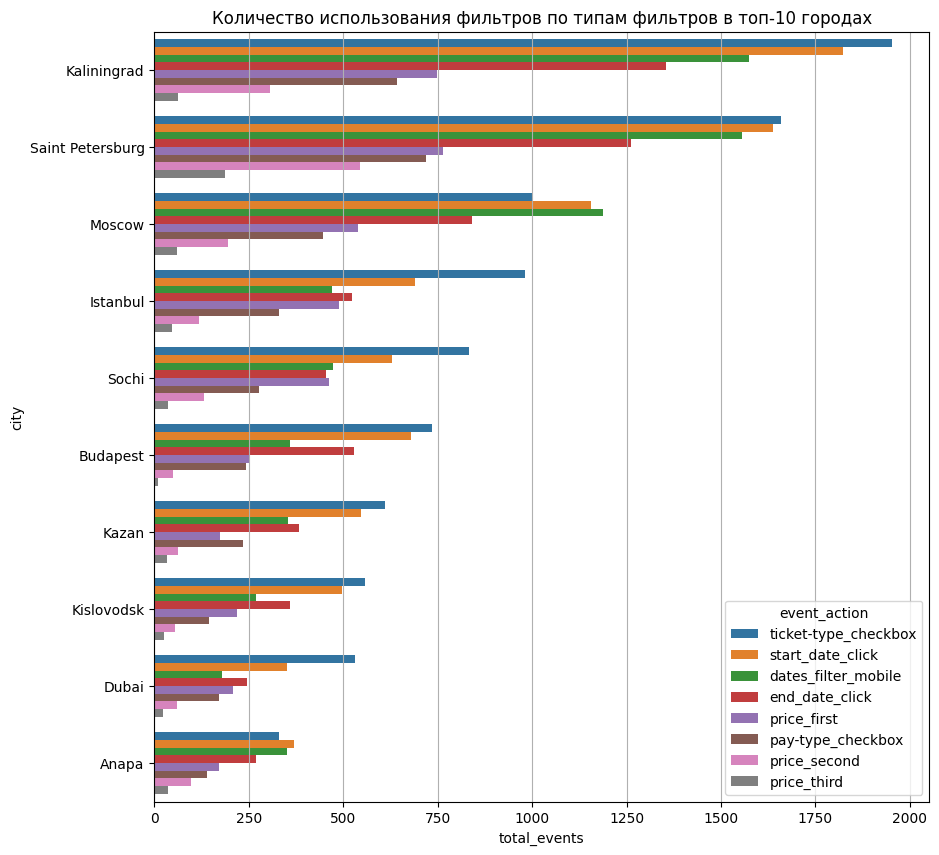

In [ ]:
plt.figure(figsize=(10, 10))
plt.grid()
plt.title('Количество использования фильтров по типам фильтров в топ-10 городах')
sns.barplot(data=cities_filters_to_analyze_grouped, x='total_events', y='city', hue='event_action')

По графику можно увидеть, что наиболее часто используемые фильтры:
- фильтр по размеру группы (ticket-type_checkbox)
- фильтр по дате начала экскурсии (start_date_click)

При этом в этих городах реже пользуются фильтрами:
- фильтр “стоимость” - третий вариант (price_third)
- фильтр “стоимость”  - второй вариант (price_second)